In [1]:
! gdown --id 1BP_ejWE3AAXU-DD3waSWXmWDNT6hMKt6

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1BP_ejWE3AAXU-DD3waSWXmWDNT6hMKt6
To: /content/dataset.zip
100% 171M/171M [00:04<00:00, 40.8MB/s]


In [2]:
from zipfile import ZipFile 
file_name = 'dataset.zip'

with ZipFile(file_name,'r') as zip: 
  zip.extractall()
  print('Done')

Done


In [3]:
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from keras.callbacks import History

import matplotlib.pyplot as plt
import numpy as np

In [4]:
IMG_HEIGHT, IMG_WIDTH = (224, 224)
BATCH_SIZE = 64

train_data_dir = "dataset/output/train/"
valid_data_dir = "dataset/output/val/"
test_data_dir = "dataset/output/test/"

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    vertical_flip=True,
    horizontal_flip=True)

valid_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical")

valid_generator = valid_datagen.flow_from_directory(
    valid_data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical")

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=1,
    class_mode="categorical")


Found 19740 images belonging to 3 classes.
Found 6579 images belonging to 3 classes.
Found 6585 images belonging to 3 classes.


In [5]:
EPOCHS = 40

base_model = ResNet50(include_top=False, weights="imagenet")

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu", kernel_regularizer=l2(0.01))(x)


predictions = Dense(train_generator.num_classes, activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

# Fine-tune
for layer in base_model.layers[-10:]:
    layer.trainable = True
    
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["acc"])

early_stopping = EarlyStopping(patience=12, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(patience=3, min_lr=0.0000001)

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=valid_generator,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate on test set
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

94765736/94765736 [==============================] - 5s 0us/step
Epoch 1/40
309/309 [==============================] - 241s 729ms/step - loss: 1.6064 - acc: 0.8109 - val_loss: 0.6313 - val_acc: 0.7991 - lr: 0.0010
Epoch 2/40
309/309 [==============================] - 222s 720ms/step - loss: 0.4316 - acc: 0.8343 - val_loss: 0.4380 - val_acc: 0.8105 - lr: 0.0010
Epoch 3/40
309/309 [==============================] - 224s 726ms/step - loss: 0.4072 - acc: 0.8367 - val_loss: 0.6834 - val_acc: 0.7609 - lr: 0.0010
Epoch 4/40
309/309 [==============================] - 222s 720ms/step - loss: 0.3960 - acc: 0.8401 - val_loss: 0.3973 - val_acc: 0.8371 - lr: 0.0010
Epoch 5/40
309/309 [==============================] - 224s 725ms/step - loss: 0.3934 - acc: 0.8442 - val_loss: 0.4269 - val_acc: 0.8250 - lr: 0.0010
Epoch 6/40
309/309 [==============================] - 222s 719ms/step - loss: 0.3896 - acc: 0.8446 - val_loss: 0.4311 - val_acc: 0.8387 - lr: 0.0010
Epoch 7/40
309/309 [=====================

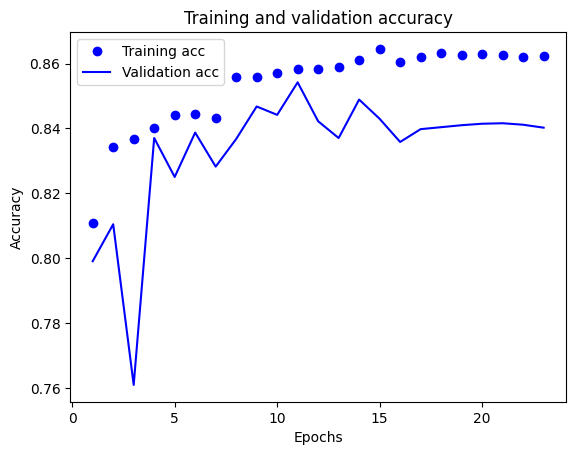

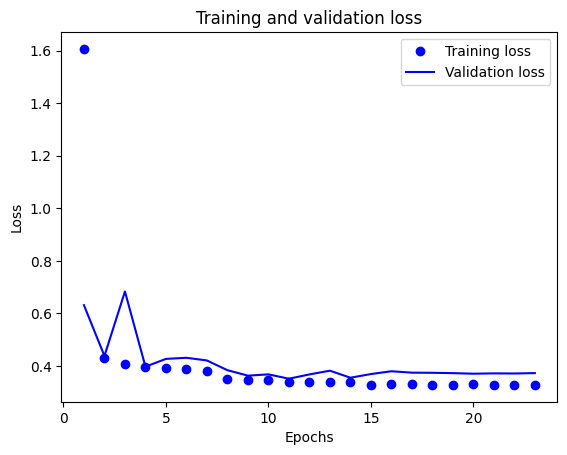

In [6]:
# Plot the training and validation accuracy and loss
history_dict = history.history
acc = history_dict["acc"]
val_acc = history_dict["val_acc"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [7]:
model.save("dataset/model/ResNet50_NOTFULL_normalFT_1.h5")

In [8]:
import pandas as pd 
import seaborn as sn 
import tensorflow as tf

model=tf.keras.models.load_model("dataset/model/ResNet50_NOTFULL_normalFT_1.h5")
filenames = test_generator.filenames 
nb_samples=len(test_generator)
y_prob=[]
y_act=[]
test_generator.reset()
for _ in range(nb_samples):
    X_test,Y_test=test_generator.next()
    y_prob.append(model.predict(X_test))
    y_act.append(Y_test)


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 25ms/step


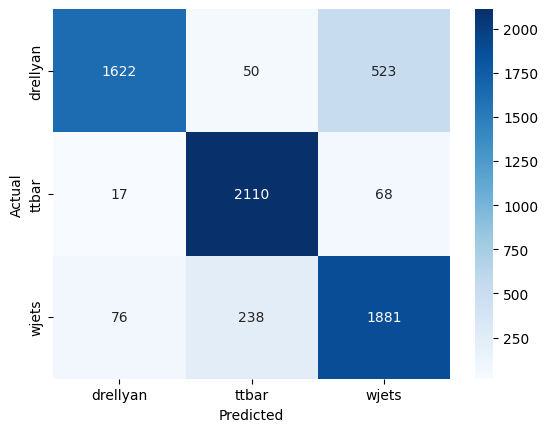

In [9]:
predicted_class=[list(train_generator.class_indices.keys())[i.argmax()] for i in y_prob]
actual_class=[list(train_generator.class_indices.keys())[i.argmax()] for i in y_act]

out_df = pd.DataFrame(np.vstack([predicted_class,actual_class]).T, columns=['predicted_class', 'actual_class'])
confusion_matrix=pd.crosstab(out_df['actual_class'], out_df['predicted_class'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix,cmap='Blues',annot=True,fmt='d')
plt.show()

<ipython-input-10-b41e292ca349>:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  confusion_matrix_norm = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]


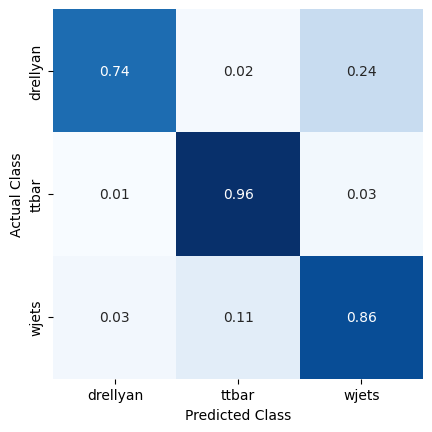

In [10]:
confusion_matrix_norm = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]

sn.heatmap(confusion_matrix_norm, cmap='Blues', annot=True, fmt='.2f', square=True, cbar=False)
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()